<a href="https://colab.research.google.com/github/joshualin24/NCSA_pytorch_tutorial/blob/main/NCSA_Pytorch_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import time
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

torch.manual_seed(1) ### import for reproducibility 

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
print("chech gpu status")
print("CUDA available?", torch.cuda.is_available())

chech gpu status
CUDA available? True


In [16]:
### hyperparameter
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = True #False


In [17]:

train_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=True,
    transform=torchvision.transforms.ToTensor(), 
    download=DOWNLOAD_MNIST,)

### data loader for processing the data in batch
train_loader = Data.DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_data = torchvision.datasets.MNIST(
    root='./mnist/', train=False)

# !!!!!!!! Change in here !!!!!!!!! #
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU
test_y = test_data.test_labels[:2000].cuda()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


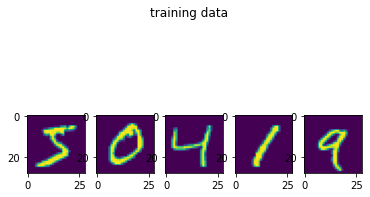

In [18]:
### visualize the data

for i in range(5):
    img = train_data.data[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
plt.suptitle("training data")
plt.show()




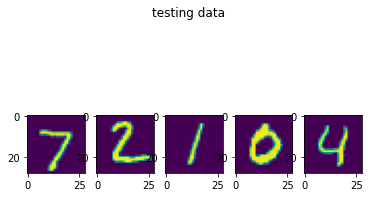

In [19]:
### visualize the data

for i in range(5):
    img = test_data.data[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
plt.suptitle("testing data")
plt.show()

Let's build a Convolutional Neural Networks with PyTorch!

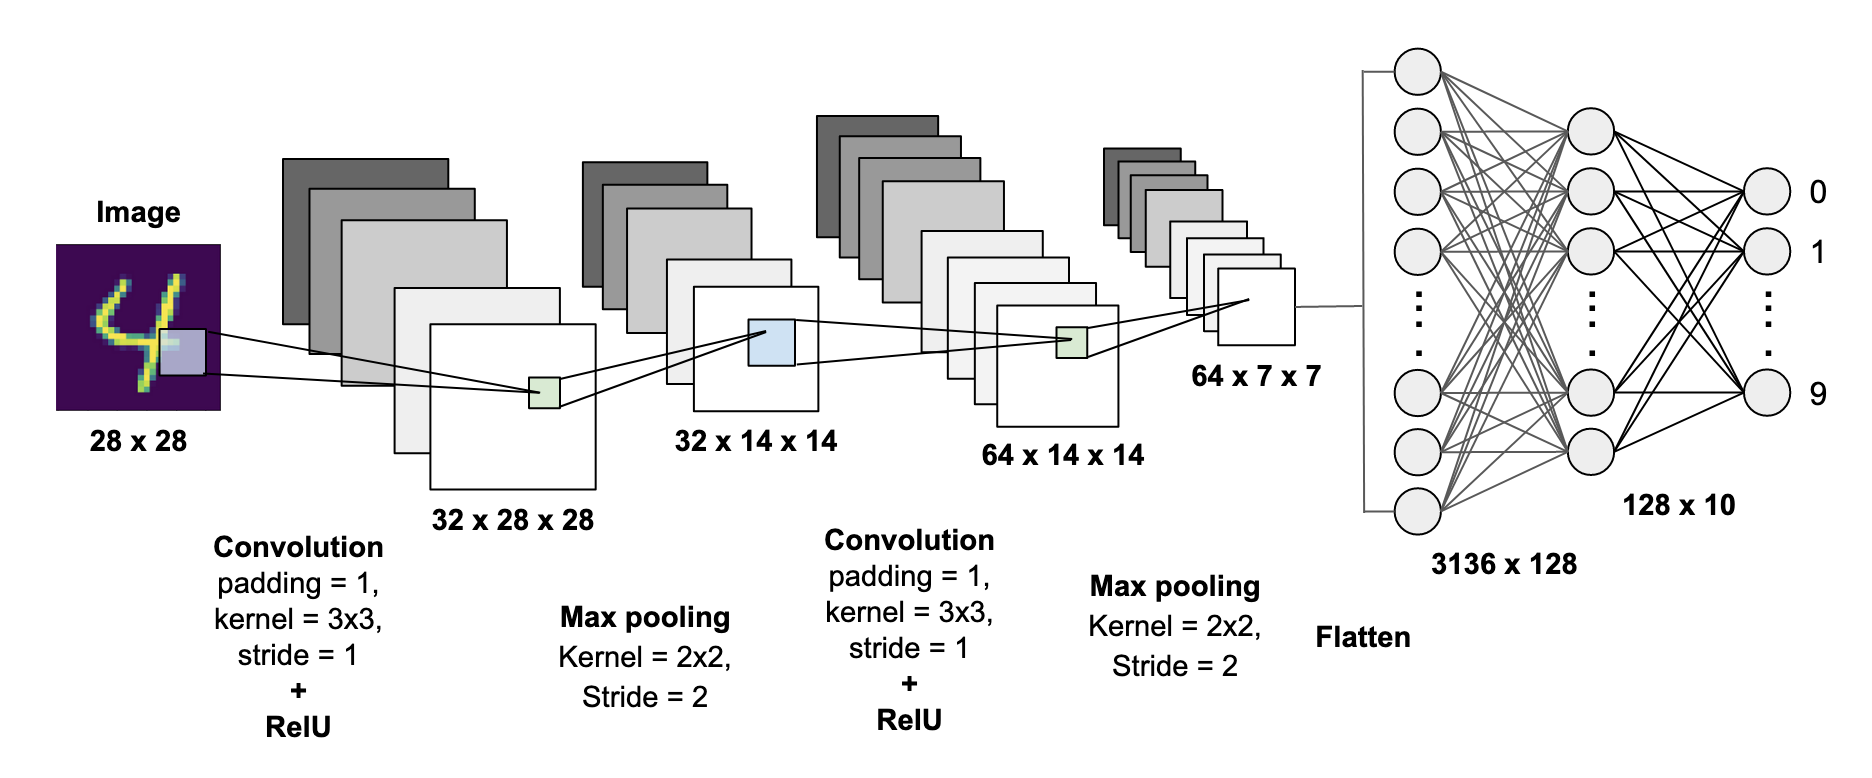

In [20]:
### build a CNN here 


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1,),                      
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.ReLU(), 
            nn.MaxPool2d(2, stride=2),)
        self.out = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2,),                      
#             nn.ReLU(), 
#             nn.MaxPool2d(kernel_size=2),)
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, 5, 1, 2), 
#             nn.ReLU(), 
#             nn.MaxPool2d(2),)
#         self.out = nn.Linear(32 * 7 * 7, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = x.view(x.size(0), -1)
#         output = self.out(x)
#         return output

cnn = CNN()

# !!!!!!!! Change in here !!!!!!!!! #
cnn.cuda()      # Moves all model parameters and buffers to the GPU.

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()



check our neural arch


In [21]:
from torchsummary import summary

summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.19
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [22]:
#Training starts here


losses_his = []

t1 = time.time()
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):

        # !!!!!!!! Change in here !!!!!!!!! #
        b_x = Variable(x).cuda()    # Tensor on GPU
        b_y = Variable(y).cuda()    # Tensor on GPU
        #print("b_y", b_y.shape, b_y)

        output = cnn(b_x)
        loss = loss_func(output, b_y)
        losses_his.append(loss.data.cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            test_output = cnn(test_x)

            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()  # move the computation in GPU

            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
            
t2 = time.time()
print("runtime:", t2- t1)

Epoch:  0 | train loss: 2.3120 | test accuracy: 0.10
Epoch:  0 | train loss: 0.6352 | test accuracy: 0.84
Epoch:  0 | train loss: 0.1427 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2580 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0435 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1805 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2082 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0534 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1390 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0565 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0407 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2210 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1269 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1808 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0961 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0523 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0322 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2060 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1402 | test accuracy

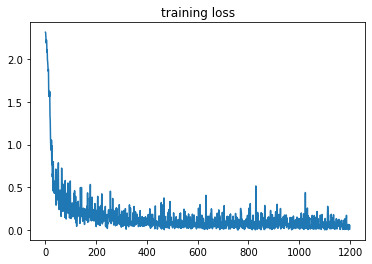

In [23]:
### plot the loss function
plt.plot(losses_his)
plt.title('training loss')
plt.show()

neural network prediction for image below: tensor(7, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


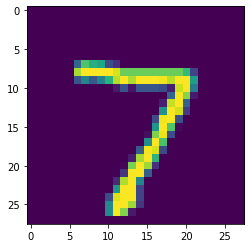

neural network prediction for image below: tensor(2, device='cuda:0')


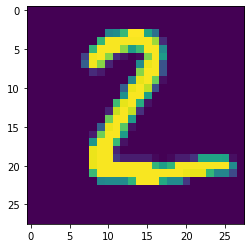

neural network prediction for image below: tensor(1, device='cuda:0')


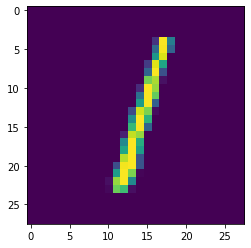

neural network prediction for image below: tensor(0, device='cuda:0')


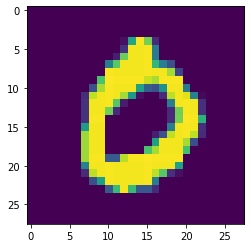

neural network prediction for image below: tensor(4, device='cuda:0')


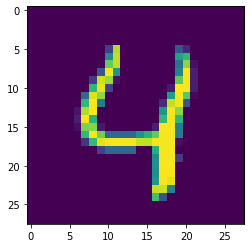

neural network prediction for image below: tensor(1, device='cuda:0')


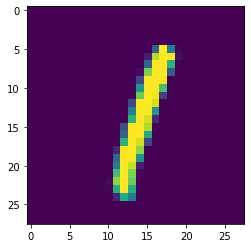

neural network prediction for image below: tensor(4, device='cuda:0')


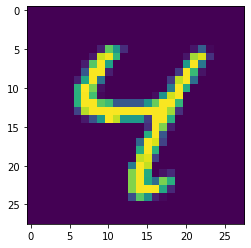

neural network prediction for image below: tensor(9, device='cuda:0')


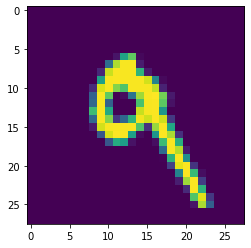

neural network prediction for image below: tensor(5, device='cuda:0')


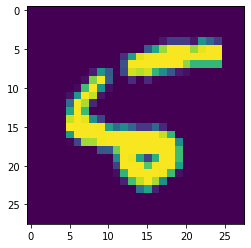

neural network prediction for image below: tensor(9, device='cuda:0')


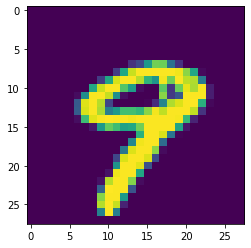

In [24]:
### visualize prediction

import numpy as np
import scipy.ndimage

test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
for i in range(10):
    img = test_data.data[i]
    valid_angles = 0 #np.random.uniform(0.0, 359.9)#[0, 90, 180, 270]
    ang = valid_angles #np.random.choice(valid_angles)
    #print("ang", ang)
    #img = rotate(img, ang, reshape=False)

    plt.imshow(img)
    pre = pred_y[np.int(i)]
    print("neural network prediction for image below:", pre)
    #print("ang", ang)
    #plt.title("neural network prediction:", pre)
    plt.show()

neural network prediction for image below: tensor(8, device='cuda:0')
label: tensor(3)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


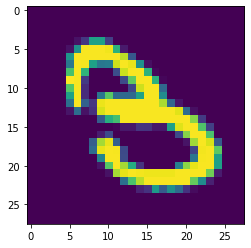

In [25]:
### visualize failed cases

test_output = cnn(test_x[:100])
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
for i in range(100):
    img = test_data.data[i]
    label = test_data.test_labels[i]


    
    pre = pred_y[np.int(i)]
    if pre != label:
      print("neural network prediction for image below:", pre)
      print("label:", label)
      
      plt.imshow(img)
      plt.show()

In [26]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [27]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [28]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [29]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [30]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [31]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.416836


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10000/60000 (17%)]	Loss: 188.094297
Train Epoch: 1 [20000/60000 (33%)]	Loss: 175.121777
Train Epoch: 1 [30000/60000 (50%)]	Loss: 165.780527
Train Epoch: 1 [40000/60000 (67%)]	Loss: 174.120391
Train Epoch: 1 [50000/60000 (83%)]	Loss: 174.129609
====> Epoch: 1 Average loss: 179.1774
====> Test set loss: 162.2548
Train Epoch: 2 [0/60000 (0%)]	Loss: 167.264004
Train Epoch: 2 [10000/60000 (17%)]	Loss: 156.416641
Train Epoch: 2 [20000/60000 (33%)]	Loss: 164.015879
Train Epoch: 2 [30000/60000 (50%)]	Loss: 159.120176
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.559102
Train Epoch: 2 [50000/60000 (83%)]	Loss: 155.918438
====> Epoch: 2 Average loss: 158.0087
====> Test set loss: 154.4325
Train Epoch: 3 [0/60000 (0%)]	Loss: 160.015371
Train Epoch: 3 [10000/60000 (17%)]	Loss: 153.116855
Train Epoch: 3 [20000/60000 (33%)]	Loss: 153.307422
Train Epoch: 3 [30000/60000 (50%)]	Loss: 151.991123
Train Epoch: 3 [40000/60000 (67%)]	Loss: 149.053164
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1

z tensor([[ 0.7756, -1.1121]], device='cuda:0')
z tensor([[-1.1000,  2.9000]], device='cuda:0')
sample torch.Size([1, 784])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


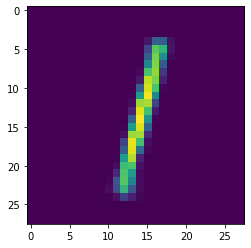

In [32]:
import matplotlib.pyplot as plt 

with torch.no_grad():
    z = torch.randn(1, 2).cuda()
    print("z", z)
    z = np.array([[- 1.1, 2.9]])
    #z = torch.tensor(z)
    z = torch.from_numpy(z).float().cuda()
    print("z", z)
    sample = vae.decoder(z).cuda()
    print("sample", sample.size())
    plt.imshow(sample[0].cpu().view(28, 28))

z tensor([[-0.9664,  0.4990]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


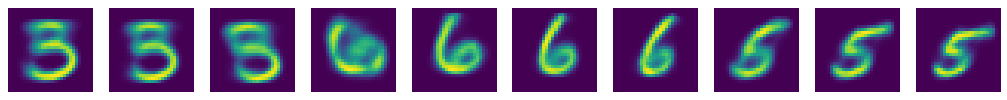

In [33]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
with torch.no_grad():
    z = torch.randn(1, 2).cuda()
    print("z", z)
    for idx, z1 in enumerate(np.linspace(-2, 2, 10)):
      z = np.array([[z1, -0.9]])
      #z = torch.tensor(z)
      z = torch.from_numpy(z).float().cuda()
      #print("z", z)
      sample = vae.decoder(z).cuda()
      #print("sample", sample.size())
      plt.subplot(1, 10, idx + 1)
      plt.imshow(sample[0].cpu().view(28, 28))
      plt.axis('off')
plt.show()